# May 30, 2022: Data samples and model
get data samples from MAX dataset. A sample is a 14TRs time series for a trial: threat/safe.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp

import torch
import torch.nn as nn 
print(torch.cuda.is_available())

import pickle, time, random
# import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy
from glob import glob

# explanation tools
import captum

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions

True


2022-05-30 20:07:46.366865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
LABELS = [0, 1] # safe, threat
max_data_path = f"{proj_dir}/data/max/data_df.pkl"
with open(max_data_path, 'rb') as f:
    max_data_df = pickle.load(f)

In [3]:
X, y = [], []
for idx_row, row in tqdm(max_data_df.iterrows()):
    subj, ts, targets = row

    for label in LABELS:
        contig_regions = dataset_utils.contiguous_regions(targets == label)

        for region in contig_regions:
            X.append(ts[region[0]: region[1], :])
            y.append(targets[region[0]: region[1]])

X = np.stack(X, axis=0)
y = np.stack(y, axis=0)

109it [00:00, 4497.80it/s]


In [4]:
print(X.shape, y.shape)

normalize = lambda z: (z - np.mean(z)) / np.std(z)

for idx_roi in np.arange(X.shape[-1]):
    X[:, :, idx_roi] = normalize(np.squeeze(X[:, :, idx_roi]))

# print(np.mean(X, axis=-1), np.mean(y, axis=-1))

(3326, 14, 85) (3326, 14)


In [5]:
X_conds = {}
for label in LABELS:
    idx = y[:, 0] == label
    X_conds[f"{label}_m"] = np.mean(X[idx, :], axis=0)
    X_conds[f"{label}_s"] = 1.96 * np.std(X[idx, :], axis=0) / np.sqrt(idx.shape[0])

# X_conds

In [6]:
roi_name_file = (
    f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
)
roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

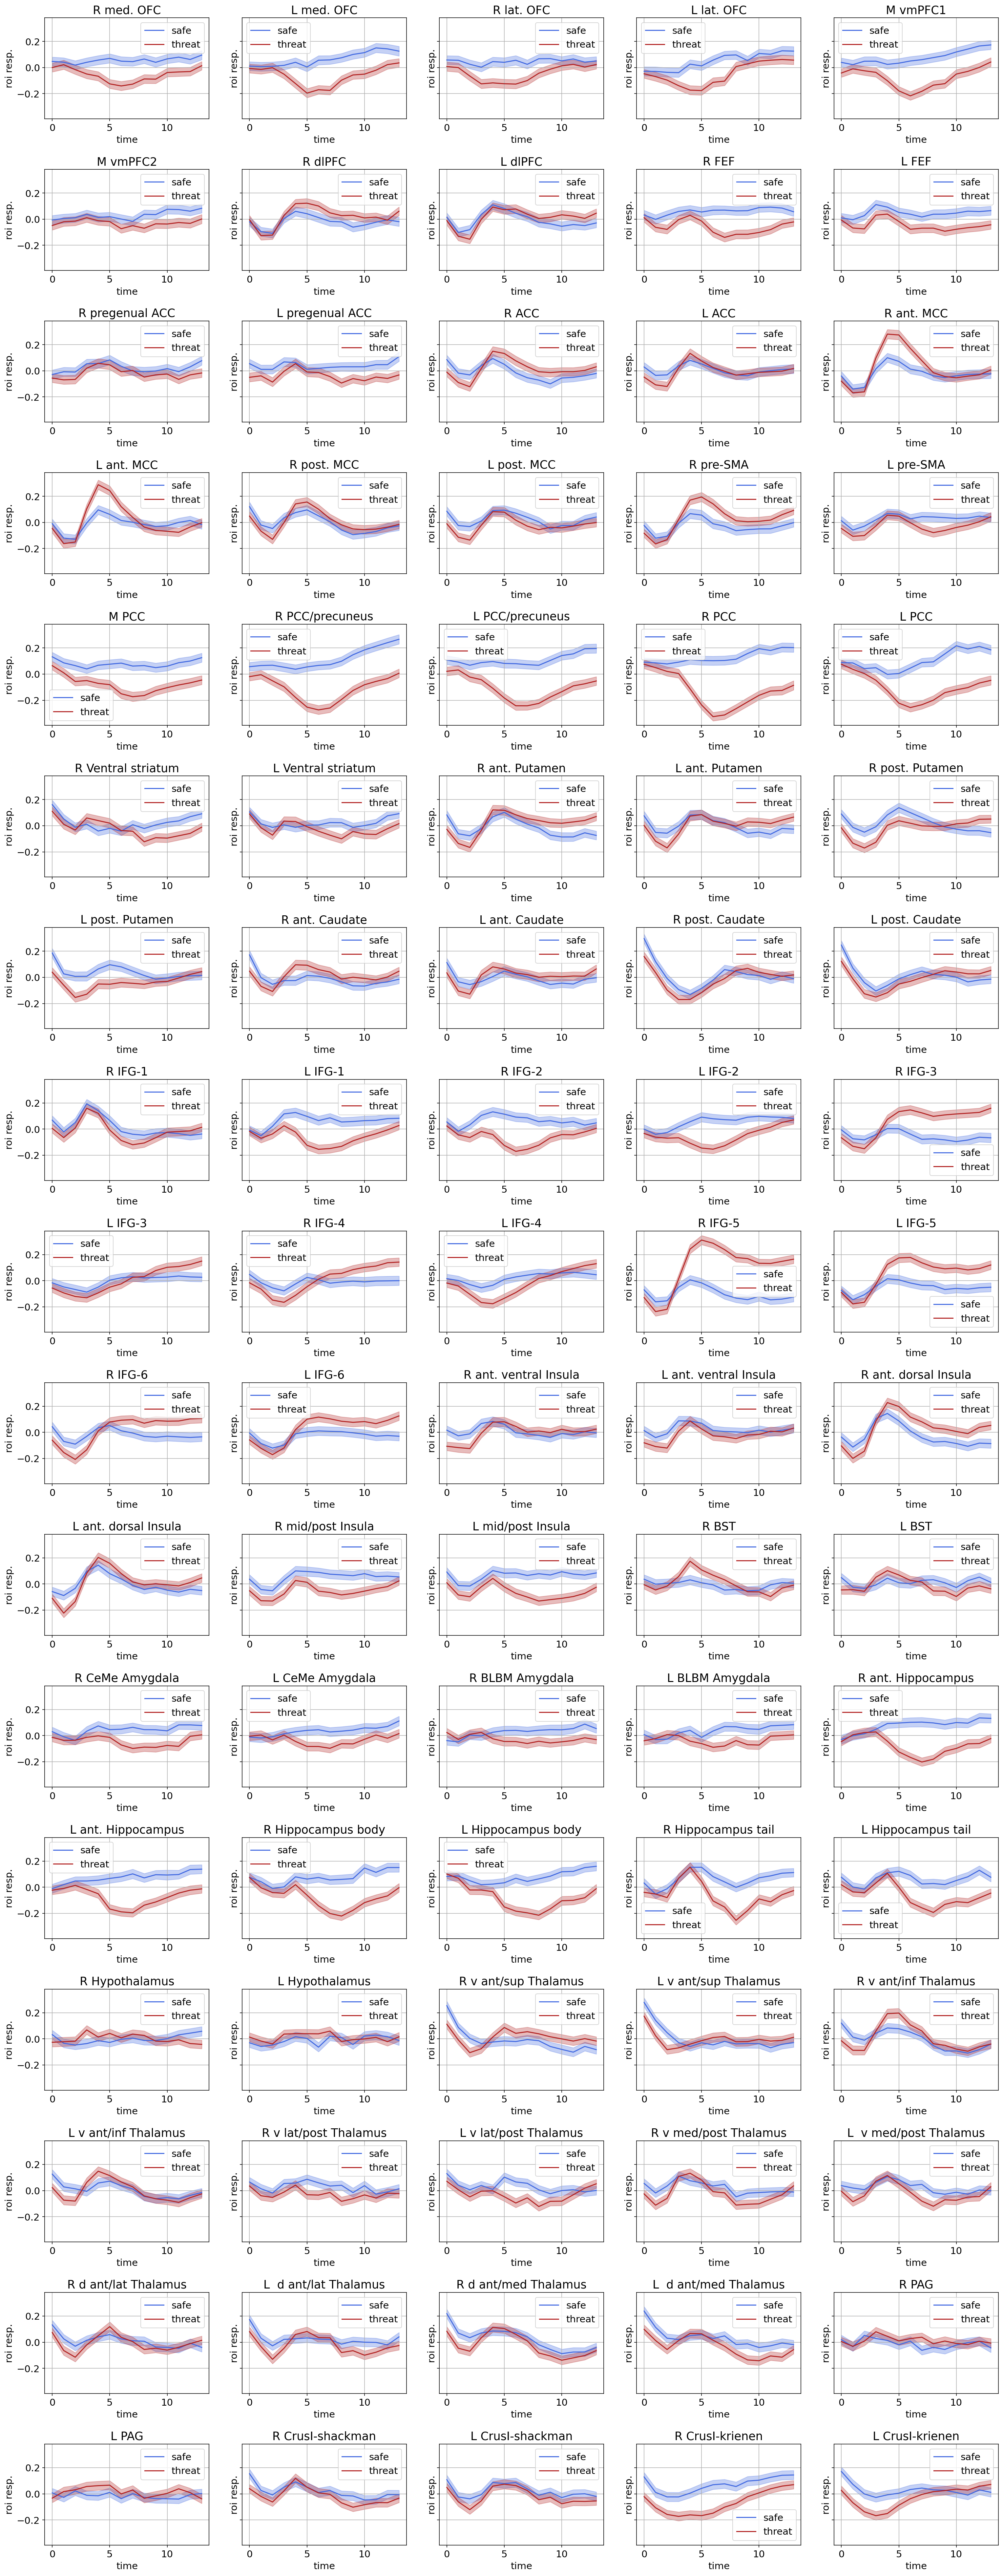

In [7]:
time = np.arange(X.shape[1])
names = ['safe', 'threat']
colors = {0:'royalblue', 1:'firebrick'}
nrows, ncols = 17, 5

fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=False, 
    sharey=True, 
    dpi=150
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.5
)

for idx_roi, roi_name in enumerate(roi_names):
    ax = axs[idx_roi//ncols, np.mod(idx_roi,ncols)]

    ax.set_title(f"{roi_name}")
    for label in LABELS:
        ts_mean = X_conds[f"{label}_m"][:, idx_roi]
        ts_std = X_conds[f"{label}_s"][:, idx_roi]

        ax.plot(ts_mean, color=colors[label], label=names[label])

        ax.fill_between(
            time, 
            (ts_mean - ts_std), 
            (ts_mean + ts_std),
            alpha=0.3, color=colors[label],
        )
    ax.set_xlabel(f"time")
    ax.set_ylabel(f"roi resp.")
    ax.grid(True)
    ax.legend()